# Lab Vision Systems: Session 3

## Today:

### 1: Solution Assignment 2

### 2: Popular CNN Architectures and Transfer Learning

### 3: Tensorboard

### 4: Transfer Learning

## Some Comments about the Assignments

 - Do not just show plots or numbers. All results need to be interpreted:
    - Why is a model is better than others
    - What is going on in this plot
    - Which classes does the model confuse. Does that make sense?
    - ...<br><br>
- Reusing code
  - Feel free to reuse you code across Lab Sessions.
  - You can make some library files (e.g., augmentations.py, visualizations.py, training_utils.py, ...) where you have your standard code, and you just simply call those files.
  - If you do this, please submit those files along with the notebook<br><br>
- Autoreload modules in ipython:
    ```
    %load_ext autoreload
    %autoreload 2        
    from Assignment_X import my_module
    ```
  

---

# 1: Solution Assignment 2

By Kashish and Manvendra

## Learning curves Max Pool
<div class="row">
    <img src="./imgs/maxpool.png" width="40%"/>
</div>

## Learning curves Avg Pool
<div class="row">
    <img src="imgs/avgpool.png" width="40%"/>
</div>

## Learning curves Strided Conv
<div class="row">
    <img src="imgs/stridedconv.png" width="40%"/>
</div>

## Learning curves Data Augmentation
<div class="row">
    <img src="imgs/dataaugm.png" width="40%"/>
</div>

## Efficient Model Architecture:
```
CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layer): Linear(in_features=1800, out_features=10, bias=True)
)

Model has 29560 parameters.

Classification accuracy: 91.77%
```
This seems like a good tradeoff between accuracy and parameter count.. (32 and 64 channels might also be a good choice (we like powers of two :-) )<br>
Using only 16 and 32 channels (like in the example from Session2) is not quite large enough for this dataset.<br>
Other groups use larger models that achieve up to ~94% accuracy: Using more / larger conv layers, or pooling not after every layer. Also, sometimes more dense layers are added.
Especially the latter significantly increases parameter count.

# 2: Popular CNN Architectures and Transfer Learning

# 3: Tensorboard

TensorBoard provides the visualization and tooling needed for machine learning experimentation:
 - https://www.tensorflow.org/tensorboard/
 - https://pytorch.org/docs/stable/tensorboard.html

In [2]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "test")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [5]:
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

2023-05-04 11:04:37.893179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
randoms = []
for i in range(int(1e4)):
    log = np.log10(i+1)
    random = np.random.randn()
    randoms.append(random)
    uniform = np.random.rand() * 2 - 1

    writer.add_scalar(f'Log Number', log, global_step=i)
    writer.add_scalars(f'Random Stuff', {
                'Gaussian': random,
                'Uniform': uniform
            }, i)
    
    if(i % 1000 == 0):
        # adding random figures
        imgs = torch.randn(16,1,16,16)
        grid = torchvision.utils.make_grid(imgs)
        writer.add_image('images', grid, global_step=i)
        
        # adding distribution
        writer.add_histogram("Sampled Gaussian", np.array(randoms), global_step=i)

# 4: Transfer Learning


In this tutorial, you will learn how to train your network using transfer learning. You can read more about the transfer learning at `cs231n notes http://cs231n.github.io/transfer-learning/

Quoting this notes,
```
In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest.
```

These two major transfer learning scenarios looks as follows:

 - **Finetuning the CNN**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on the Imagenet dataset. Rest of the training looks as usual.
 
 - **CNN as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected classifier. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
 
 - **Combined Approach**: Training first the classifier only, and then doing some joined fine-tuning of both CNN feature extractor and classifier

In [7]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

## Data Loading

We will use torchvision and torch.utils.data packages for loading the data.

The problem we're going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [ ]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip #Download the data from

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

N_train = len(train_dataset)
N_valid = len(valid_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4)



Training set size: 244 images
Valdiation set size: 153 images


In [9]:
class_names = train_dataset.classes
print(class_names)

['ants', 'bees']


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Visualizing some Images

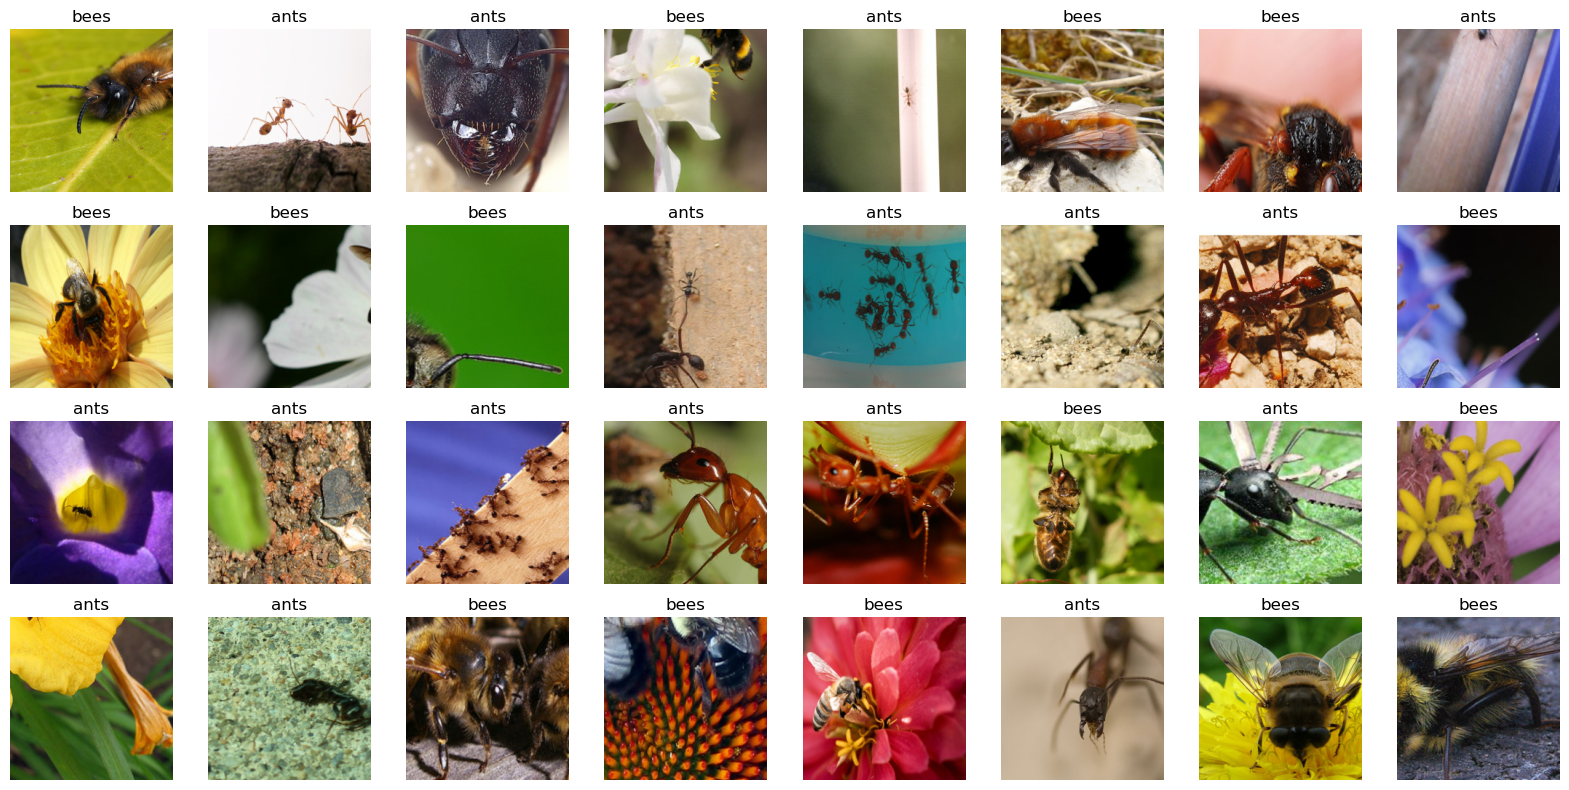

In [11]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
# Get a batch of training data and displaying it
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

## Main Code

In [12]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        writer.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [13]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

## Model

We get a pretrained ResNet-18 model. We keep the convolutional part, but drop the fully-connected classification head and make one of our own.

In [14]:
set_random_seed()

In [15]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # pretrained=True

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# replacing classification head
num_nuerons = model.fc.in_features
model.fc = nn.Linear(num_nuerons, 2)

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,2)
)

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training Our Model

In [21]:
# downloading pretrained model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #pretrained=True  # https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

# replacing classification head
num_nuerons = model.fc.in_features
model.fc = nn.Linear(num_nuerons, 2)

model = model.to(device)

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## 1. Fine-Tuning

The number of images is very small, so it trains very fast on a GPU

In [24]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNN_tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [25]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer
    )

Epoch 1/15
    Train loss: 0.35117
    Valid loss: 0.77734
    Accuracy: 50.326797385620914%


Epoch 6/15
    Train loss: 0.09687
    Valid loss: 0.26829
    Accuracy: 94.11764705882352%


Epoch 11/15
    Train loss: 0.09029
    Valid loss: 0.38964
    Accuracy: 92.81045751633987%


Epoch 15/15
    Train loss: 0.07126
    Valid loss: 0.335
    Accuracy: 92.81045751633987%


Training completed


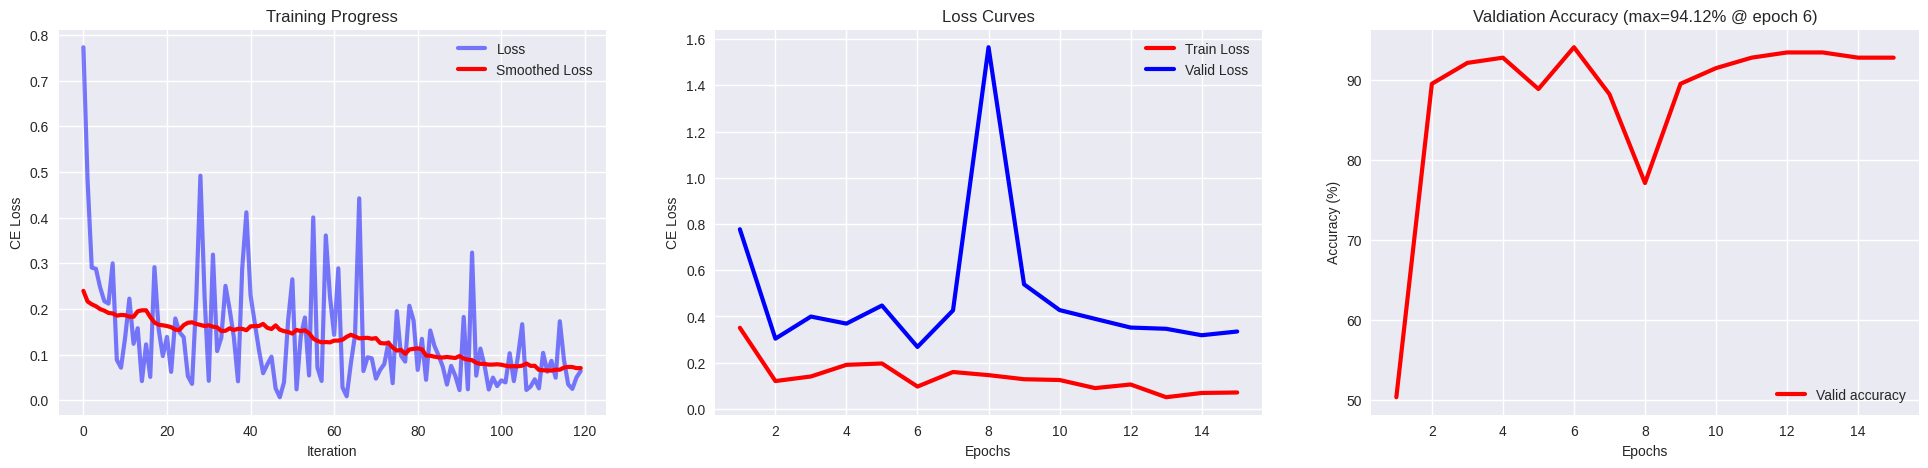

In [26]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

## 2. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation `here http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward

In [27]:
set_random_seed()

In [28]:
fixedModel = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #pretrained=True

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_logits = fixedModel.fc.in_features
fixedModel.fc = nn.Linear(num_logits, 2)
fixedModel = fixedModel.to(device)

In [29]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNN_fixed")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [31]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=fixedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

Epoch 1/15
    Train loss: 0.73083
    Valid loss: 0.68681
    Accuracy: 60.78431372549019%


Epoch 6/15
    Train loss: 0.46795
    Valid loss: 0.48601
    Accuracy: 83.00653594771242%


Epoch 11/15
    Train loss: 0.41569
    Valid loss: 0.41609
    Accuracy: 88.88888888888889%


Epoch 15/15
    Train loss: 0.39417
    Valid loss: 0.40636
    Accuracy: 89.54248366013073%


Training completed


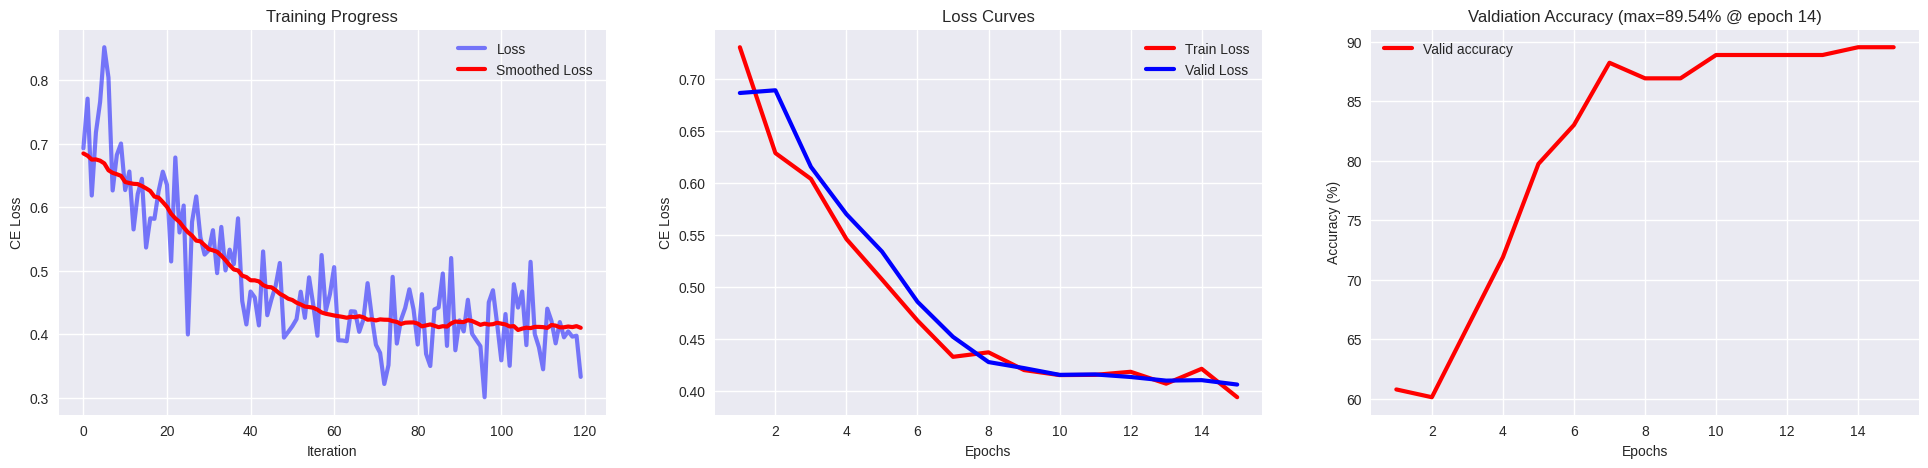

In [32]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

## Combined Approach

 - First train only the classifier for 10 epochs
 - Unfreezing the backbone and fine-tuning for 10 more epochs with a lower learning rate

In [33]:
set_random_seed()

In [34]:
fixedModel = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #pretrained=True

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_logits = fixedModel.fc.in_features
fixedModel.fc = nn.Linear(num_logits, 2)
fixedModel = fixedModel.to(device)

In [35]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=3e-4)

In [36]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNN_combined")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [37]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=fixedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=10, tboard=writer, start_epoch=0
    )

Epoch 1/10
    Train loss: 0.73083
    Valid loss: 0.68681
    Accuracy: 60.78431372549019%


Epoch 6/10
    Train loss: 0.46795
    Valid loss: 0.48601
    Accuracy: 83.00653594771242%


Epoch 10/10
    Train loss: 0.36875
    Valid loss: 0.37017
    Accuracy: 90.19607843137256%


Training completed


In [38]:
# Unfreezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = True

In [39]:
# Lowering learning rate
for g in optimizer.param_groups:
    g['lr'] *= 0.1

In [40]:
next_train_loss, next_val_loss, next_loss_iters, next_valid_acc = train_model(
        model=fixedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=10,  tboard=writer, start_epoch=10
    )

Epoch 1/10
    Train loss: 0.32323
    Valid loss: 0.35621
    Accuracy: 90.84967320261438%


Epoch 6/10
    Train loss: 0.09571
    Valid loss: 0.18474
    Accuracy: 93.4640522875817%


Epoch 10/10
    Train loss: 0.12447
    Valid loss: 0.18313
    Accuracy: 94.77124183006535%


Training completed


In [41]:
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_loss_iters = loss_iters + next_loss_iters
concat_valid_acc = valid_acc + next_valid_acc

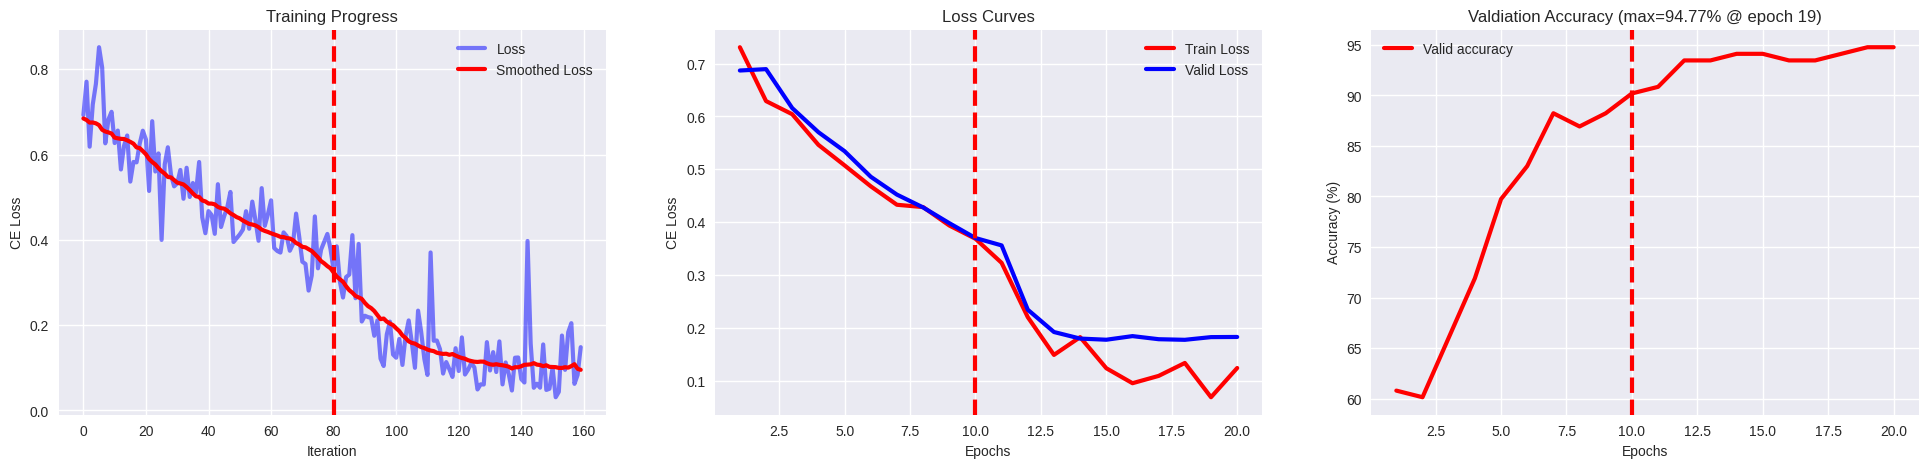

In [42]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(concat_loss_iters, 31)
ax[0].plot(concat_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")
ax[0].axvline(x=len(loss_iters), color="red", ls="--", linewidth=3)

epochs = np.arange(len(concat_train_loss)) + 1
ax[1].plot(epochs, concat_train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, concat_val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")
ax[1].axvline(x=10, color="red", ls="--", linewidth=3)

epochs = np.arange(len(concat_val_loss)) + 1
ax[2].plot(epochs, concat_valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(concat_valid_acc),2)}% @ epoch {np.argmax(concat_valid_acc)+1})")
ax[2].axvline(x=10, color="red", ls="--", linewidth=3)

plt.show()

# Assignment 3

## Pet Classiciation on a 'small' dataset:
 #### - Oxford-IIIT Pets Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/
 - 7,349 images
 - 37 classes (pet-breeds), or cat vs. dog (2 classes)
 - On average, 200 images per class
 
 #### **Important**: For Experiment 1, the task is cat vs dog classification.<br>To make this more challenging, select only 1000 random dog and 1000 random cat images. Discard the rest.


### **Augmentations**

For your experiments, use augmentations from the following types:
- Spatial Augmentations (rotation, mirroring, croppoing, ...)
- Use some other augmentations (color jitter, gaussian noise, ...).
- Use one (or more) of the following advanced augmentations:
   - **Mixup**: https://arxiv.org/pdf/1710.09412.pdf
   - **CutMix**: https://arxiv.org/pdf/1905.04899.pdf

### **Experiments:** 
#### **Experiments 1:**
 Using your **reduced cat vs. dog dataset** and the aforementioned augmentions:
 - Fine-tune VGG, ResNet and MobileNetV3 for your augmented dataset for **cat vs. dog classification (2 classes)** and compare them.
 - Compare the following: Fine-Tuned ResNet, ResNet as fixed feature extractor, and ResNet with a Combined Approach
 - Log your losses and accuracies into Tensorboard (or some other logging tool like WandB)
 - **Extra Point**: 
   - Fine-tune a Transformer-based model (e.g. ViT, EdgeNext). Compare the performance (accuracy, confusion matrix, training time, loss landscape, ...) with the one from ResNet.
   
#### **Experiment 2:**
Using the **original dataset (2.4k cats and 5k dogs)**, try to get the best performance possible:
 - Fine-tune a pretrained neural network of your choice for **animal breed classification (37 classes)**.
 - Select a good training recipe: augmentations, optimizer, learning rate scheduling, classifier, loss function, ...


#### **Due Date**: Tuesday May 9 at 23:59 (Experiment 1)<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tuesday May 16 (Experiment 2)
#### Submit it by mail using the subject: **CudaLab: Assignment3 + Group Name**
#### Send me the following: Jupyter Notebook after running, Jupyter export as html, any other .py files or images used.

### **Next Session: Thursday May 11, Room 0.016**

#### **Following Sessions**:
Thursday, May 25, Room 0.016<br>
Thursday, June 15, Room 0.016<br>
Thursday, June 29, Room 0.016<br>
Thursday, July 13, Room 0.016

# References

 - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
 - https://www.deeplearningbook.org/
 - http://cs231n.stanford.edu/
 - https://towardsdatascience.com/classifying-images-of-alcoholic-beverages-with-fast-ai-34c4560b5543

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Simon Bultmann</b><br>
    <ul>
       <li> <b>Email</b>: bultmann@ais.uni-bonn.de
       <li> <b>Website</b>: https://www.ais.uni-bonn.de/~sbultmann/
    </ul>
</div> 